In [1]:
%matplotlib widget
from helper import *
from DualQuaternionQuinticBlends.LineGenerator import LineGenerator
from DualQuaternionQuinticBlends.ArcGenerator import ArcGenerator
from DualQuaternionQuinticBlends.DQQBTrajectoryGenerator import DQQBTrajectoryGenerator

# Dual Quaternion Interpolation

To facilitate the previously derived Dual Quaternion Differential Kinematics, we need to provide a method that is able to interpolate in the dual quaternion space $\mathbb{H}$. This Interpolation requires a certain continuity to ensure the physical robot is able to follow the given pose at any times. that means no jumps on position, velocity or acceleration level should be allowed. This means that the interpolation scheme at least needs constant jerk, which is the third derivative of the position level interpolation. Besides the continuity requirement it is also mandatory that velocity, acceleration and jerk limits are not violated to allow the robot to follow the trajectory well with given hardware limits or to the satisfaction of special requirements set by the tool or the user.

The chosen interpolation scheme is a methodogical extension of the newly proposed <i>Spherical Cubic Blend</i> (SCB) algorithm <cite id="efaml"><a href="#zotero%7C16222978%2FTFYY7RAS">(Wittmann et al., 2023)</a></cite>, which was, besides other methods, introduced in the state of the art. Here, instead of only interpolating the orientation unit quaternions with help of a blending period, we extend the method to the translational interpolation with the help of quintic polynomials.
Due to the quintic and cubic Blending of a set of Dual Quaternions, the proposed method is named <strong>Dual Quaternion Quintic Blends (DQQB)</strong>. 

Similarly to the SCB algorithm, the orientation is done on angular velocity level to avoid interpolation in $S^3.$
This simplifies the interpolation and blending of the velocity jumps, as the angular velocity is given in flat space $\mathbb{R}^3$. This allows for the application of simple interpolation schemes instead of complicated interpolation on the curved surface of the unit quaternion hypersphere. The interpolated orientation quaternion $q_{r, int}$ can then be computed from the interpolated angular velocity $\omega_{int}$ through quaternion integration.

Different motiontypes must be covered to make the algorithm useful in pracitical applications, namely <i>Move Linear</i> and <i>Move Circular</i>, as well as the combination of both, called <i>Move Composite</i>.

The DQQB Algorithm can be subdivied into an <strong>offline optimization algorithm</strong> and the <strong>online interpolation algorithm</strong>, which can be called in the realtime environment to retrieve the interpolated dual quaternion $\underline{\xi}_{int}$ and the respective derivatives. The offline optimization takes a set of Segements $\mathbb{S} = [seg_1, seg_2, \dots, seg_3]$, which are either of the type line or arc. Composite motion is a set with both arc and line segments.

<h2>Segment Generation</h2>

Segments for the interpolation are defined via a set of unit dual quaternion poses $\mathbb{X} = [\underline{\xi}_1, \underline{\xi}_2, \dots, \underline{\xi}_n]$, a desired translational velocity $v_{des}$ and a maximum angular velocity $\omega_{max}$. The dual quaternions in the list are then converted to segments. Depending on whether the segment is a line or an arc, two or three dual quaternion poses $\underline{\xi}_i$ are needed per segment. Lines are defind with two positions per line. Arcs are defined with the common three point method, but are then saved for each two points to accomodate for orientation change of the second point on the circle segment. This operation is done via a sliding window to be able to also approximate more complex shapes with this arc chain.

Saved properties of the segment objects needed for the offline optimization and online interpolation include:
<ul>
    <li> the total duration of the segment: $h_{segment}$</li>
    <li> the inital orientation quaternion: $q_{0}$ </li>
    <li> the current cartesian position: $p(t)$ </li>
    <li> the current cartesian velocity: $v(t)$ </li>
    <li> the current cartesian acceleration: $a(t)$ </li>
    <li> the current angular velocity: $\omega(t)$ </li>
</ul>

To explain the calculation and generation of arc and line segments more thoroughly the segment generation for the more complicated arc segments is introduced.

In [2]:
def generateSegments(self, DQ_list, velocity, angular_velocity_max):
    
        # total number of arcs is one less than the number of unit dual quaternions from the list
        number_of_arcs = len(DQ_list)-1
        self.arc_list = []
        is_last_arc = False
        
        # iterate over all unit dual quaternions to generate arcs
        for i in range(number_of_arcs-1):
                
                # flag to indicate if the last 3 points will generate the last 2 arcs
                if i == number_of_arcs - 2:
                        is_last_arc = True
                        
                # generate arcs for triplets of dual quaternions
                self.generateArcs(DQ_list[i], DQ_list[i+1], DQ_list[i+2], is_last_arc, velocity, angular_velocity_max)
        
        # return the list of arc segments
        return self.arc_list
    
def generateArcs(self, dq1, dq2, dq3, is_last_arc, velocity, angular_velocity_max):
    
        # Extract position from the unit dual quaternions
        p1 = dq1.getPosition().flatten()
        p2 = dq2.getPosition().flatten()
        p3 = dq3.getPosition().flatten()

        # calculate the center and radius of the arc from three points
        center, radius = self.calcCenterAndRadius(p1, p2, p3)
        
        # vectors from center to each point
        v_center_start_ = p1 - center
        v_center_mid_ = p2 - center
        v_center_end_ = p3 - center
        
        # normalization of the vectors
        v_center_start = v_center_start_/np.linalg.norm(v_center_start_)
        v_center_mid = v_center_mid_/np.linalg.norm(v_center_mid_)
        v_center_end = v_center_end_/np.linalg.norm(v_center_end_)
        
        # compute rotation matrix from start and mid vector
        rotation = self.computeRotationMatrix(v_center_start, v_center_mid)
        
        # compute angle between start and mid vector
        angle = self.calculateAngleBetweenVectors(v_center_start, v_center_mid)
        
        # append arc segment that stretches from the first to the second point
        self.arc_list.append(Arc(dq1, dq2, velocity, angular_velocity_max, center, radius, rotation, angle))
        
        # in case we have the last triplet of the dual quaternion list, 
        # append second arc from second to third point as well
        if is_last_arc:
                
                # update the rotation matrix with mid and end vector
                rotation = self.computeRotationMatrix(v_center_mid, v_center_end)
                
                # compute angle between mid and end vector
                angle = self.calculateAngleBetweenVectors(v_center_mid, v_center_end)
                
                # append last arc
                self.arc_list.append(Arc(dq2, dq3, velocity, angular_velocity_max, center, radius, rotation, angle))

The above algorithm shows how the arc segments are generated. More details can also be found in the <a href="./DualQuaternionQuinticBlends/ArcGenerator.py">ArcGenerator.py</a> file provided in the DQQB package. There, also the LineGenerator is implemented (<a href="./DualQuaternionQuinticBlends/LineGenerator.py">LineGenerator.py</a>), where the details of implementaiton are significantly easier than in the ArcGenerator.

To generate a set of Segments we first define a two sets of unit dual quaternions $\mathbb{X}_1$ and $\mathbb{X}_2$  and then generate line and arc segments to later show a move Composite motion. The following code block will define seven different poses as unit dual quatenrions, each given a rotation quaternion $q_i$ and a cartesian position $p_i$, as common in solving tasks in the workspace of the robot. These dual quaternions are then used to define line segments, followed by subsequent arcs. These segments are generated as described above by calling their respective segment gererators and then concatenated for futher usage of the DQQBTrajectoryGenerator later.

In [16]:
# define orientation quaternions for test trajectory
q1 = Quaternion(0.454, -0.891, -0.000, -0.000)
q2 = Quaternion(0.321, -0.630, -0.630, 0.321)
q3 = Quaternion(0.219, -0.219, -0.672, 0.672)
q4 = Quaternion(-0.267, -0.275, -0.847, 0.367)
q5 = Quaternion(-0.367, -0.721, -0.524, -0.267)

# define dual quaternions for linear interpolation
dq1 = DualQuaternion.fromQuatPos(q1, np.array([-0.4, 0, 0]))
dq2 = DualQuaternion.fromQuatPos(q1, np.array([0, 0, 0 ]))
dq3 = DualQuaternion.fromQuatPos(q2, np.array([0, 0, 0 ]))
dq4 = DualQuaternion.fromQuatPos(q2, np.array([0, 0.3, 0 ]))

# define dual quaternions for circular interpolation
dq5 = DualQuaternion.fromQuatPos(q3, np.array([-0.3, 0.6, 0.1]))
dq6 = DualQuaternion.fromQuatPos(q4, np.array([-0.5, 0.55, 0.2]))
dq7 = DualQuaternion.fromQuatPos(q5, np.array([-0.6, 0.3, 0.3]))

# assign dual quaternions to lists
line_DQ_list = [dq1, dq2, dq3, dq4]
arc_DQ_list = [dq4, dq5, dq6, dq7]

# initialize line and arc generators
line_generator = LineGenerator()
arc_generator = ArcGenerator()

# define desired cartesian velocites and maximum angular velocity
des_cart_vel_line = 0.5
des_cart_vel_arc = 0.3
max_ang_vel = 3

# generate segments
line_segments = line_generator.generateSegments(line_DQ_list, des_cart_vel_line, max_ang_vel)
arc_segments = arc_generator.generateSegments(arc_DQ_list, des_cart_vel_arc, max_ang_vel)

# merge segments into one segment list
segments = line_segments + arc_segments

<h2>Translation Interpolation of the DQQB Algorithm</h2>

The translational interpolation of the segments is based on simple segment interpolation and a subsequent blending during the offline optimization algorithm. First the segment functions $p(t)$, $v(t)$, $a(t)$ need to be defined. These functions are based on the geometric information of the segment type and the position input, as well as the desired translational velocity.

The total distance traversed by the translational motion on the unblended base segments is defined as follows: 
<ul>
    <li> for line: $d = \|p_1 - p_2\|$, where $p_1$ and $p_2$ are the cartesian positions that define the line segment.</li>
    <li> for arc: $d = \phi r$, where $\phi$ is the angle that defines the arc segment and $r$ is the radius.</li></ul>

The total motion duration of each segment is then computed with the assumption that the segment is traversed with a constant velocity $v_{des}$.

$$
 h_{segment} = \frac{d}{v_{des}}
$$

This duration may later be adjusted during the offline optimization algorithm, depending on the feasibility of the blending of the segments. Thus, the kinematic functions have to depend on it, and not the desired velocity $v_{des}$.
Once again the computation of position, velocity and acceleration of the line segment is trivial, so the following functions define the position, velocity and acceleration of the arc segments.

In [17]:
 def getPosition(self, time):
        point_on_arc = np.array([self.radius*np.cos(time/self.duration*self.angle),
                                 self.radius*np.sin(time/self.duration*self.angle),
                                 0])

        translation = self.center + self.rotation@point_on_arc

        return translation

def getVelocity(self, time):
        velocity = np.array([-self.radius * np.sin(time/self.duration * self.angle) 
                                     * self.angle/self.duration,
                             self.radius * np.cos(time/self.duration * self.angle) 
                                     * self.angle/self.duration,
                             0])

        rotated_velocity = self.rotation @ velocity
        
        return rotated_velocity

def getAcceleration(self, time):
        acceleration = np.array([-self.radius * np.cos(time/self.duration * self.angle) 
                                             * (self.angle/self.duration)**2,
                                 -self.radius * np.sin(time/self.duration * self.angle) 
                                             * (self.angle/self.duration)**2,
                                 0])

        rotated_acceleration = self.rotation @ acceleration
        
        return rotated_acceleration

As seen, the position is computed by a simple 2D cirlce segment computed by $\sin$ and $\cos$ functions and is then rotated in space by the rotation matrix computed in the <a href="./DualQuaternionQuinticBlends/ArcGenerator.py">ArcGenerator.py</a> file. The velocity and acceleration is computed as derivative of the position. As mentioned before, all functions are not dependent on the desired velocity $v_{des}$, but from the total duration $h_{segment}$ and the angle $\phi$.

<h2>Orientation Interpolation of the DQQB Algorithm</h2>

As the unit quaternions $\hat{q}_{r, i} \in S^3$ require unit length to represent orientations and rotations, it is preferable to interpolate on angular velocity level as $\omega \in \mathbb{R}^3$. This allows for the application of standard cubic polynomials without consideration of the curved unit quaternion space $S^3$.

To calculate the angular velocity on the segment the relative rotation axis $\hat{n}$ between the two orientation quaternions $\hat{q}_{r, 1} = Real(\underline{\xi}_1)$  and $\hat{q}_{r, 2} = Real(\underline{\xi}_2)$ has to be extracted.

As introduced in Chapter 3.0 this computation can be done with the log map of the unit quaternions and following renormalization. Special care has to be taken if we are close to the zero-angle singularity as this means that $\| log(\hat{q}_{r,1}^* \otimes \hat{q}_{r,2})\| \to 0$, if the difference between the interpolated quaternions is small, i.e. $\hat{q}_{r,1}^* \otimes \hat{q}_{r,2} \to (1,0,0,0)$.

In [18]:
q1 = Quaternion(0.0, 0.7071, 0.7071, 0.0)
q2 = Quaternion(0.0, 0.0, 0.0, 1.0)


delta_q = q1.inverse()*q2
r = delta_q.log().normalize()
print(r)

Quaternion(0.000, -0.707, 0.707, 0.000)


As the resulting pure quaternion $\bar{r} = (0, \hat{n})$ is not given in the base frame but is rotated by the quaternion $\hat{q}_1^*$, it has to be rotated back to the base frame according to the procedure we have introduced in Chapter 3.0.

$$
\bar{r}^0 = \hat{q}_0^1 \otimes \bar{r}^{1} \otimes \hat{q}_0^{1*} 
$$


In [19]:
r_base = q1*r*q1.inverse()
print(r_base)

Quaternion(0.000, 0.707, -0.707, 0.000)


To compute the required angular velocity we need the angle between the two orientation quaternions. 
The angle between $\hat{q}_{r,1}$ and $\hat{q}_{r,2}$ is the same angle as the angle of $\Delta \hat{q} = \hat{q}_{r,1}^* \otimes \hat{q}_{r,2}$ to the identiy quaternion. This angle can be computed in a robust manner with the $atan2$ function:

$$
\theta = 2 atan2(\| Im(\Delta \hat{q})\|, Re(\Delta \hat{q}))
$$

In [20]:
theta = delta_q.getAngle()

print(theta)

3.141592653589793


This allows us then to compute the angular velocity $\omega$ with the total segment duration of the constant velocity phase $h_{total}$.

$$
\omega = Im(\bar{r}^0) \frac{\theta}{h_{segment}}
$$

Note, if $\omega > \omega_{max}$, the total duration $h_{segment}$ has to be updated to make sure that both cartesian velocity and angular velocity limit are not violated.

$$
h_{segment} = \frac{\theta}{\omega_{max}}
$$

For both line and arc segments, the angular velociy on the segment is assumed to be constant before blending is applied. This gives the angular velocity function as follows for both types of segment:

In [21]:
def getAngularVelocity(self):
        return self.rotation_axis*self.theta/self.duration

<h2>Offline Optimization Algorithm</h2>

After the segment generation, the segments each have a translational and angular velocity, which is not neccessarily equal in direction and magnitude from segment to segment. This means, that the velocity has jumps at the connection of two segments. These jumps are inacceptable and thus a blending between translational velocities and angular velocites is needed. Blending for the angular velocity is done via cubic polynomials instead of the in <cite id="s8wjb"><a href="#zotero%7C16222978%2FTFYY7RAS">(Wittmann et al., 2023)</a></cite> proposed trapezoidal motion profile with constant jerk, as the application is simpler and more straight-forward. Cubic polynomials are easily extendible to quintic polynomials, which are used for the translational interpolation. The translational interpolation is done on position level.

Computation of these blend segments need a few parameters, which are used in the online interpolation algorithm and computed in the offline optimization. 

These parameters include:
<ul>
    <li>The durations of the trajectory blends: $H_{blend}$</li>
    <li>The durations of the segments: $H_{segment}$</li>
    <li>The angular velocities at the beginning of the angular velocity blends: $\Omega_{blend, 0}$</li>
    <li>The angular velocities at the end of the angular velocity blends: $\Omega_{blend, 1}$</li>
    <li>The cartesian positions at the beginning of the cartesian blends: $P_{blend, 0}$</li>
    <li>The cartesian positions at the end of the cartesian blends: $P_{blend, 1}$</li>
    <li>The cartesian velocities at the beginning of the cartesian blends: $V_{blend, 0}$</li>
    <li>The cartesian velocities at the end of the cartesian blends: $V_{blend, 1}$</li>
    <li>The cartesian accelerations at the beginning of the cartesian blends: $A_{blend, 0}$</li>
    <li>The cartesian accelerations at the end of the cartesian blends: $A_{blend, 1}$</li>
    <li>The times specifying when each pose is reached: $T_{traj}$</li>
    <li>The times specifying when the blending phases start: $T_{bStart}$</li>
</ul>

The Lists $P_{blend, 0}$, $P_{blend, q}$,$V_{blend, 0}$, $V_{blend, 1}$, $A_{blend, 0}$ and $A_{blend, 1}$ are defined to define the quintic splines for the position interpolation and $\Omega_{blend, 0}$ and $\Omega_{blend, 1}$ are needed for the orientation interpolation with cubic splines on velocity level. Note, that for the line segments the accelerations is zero. The acceleration terms $A_{blend, 0}$ and $A_{blend, 1}$ are only unequal to $(0,0,0)$ for the arc segments, which also explains why quintic splines are required for the cartesian interpolation. Would the DQQB Interpolator only handle linear segments, the cubic blending on velocity level, similar to orientation interpolation would suffice.

The quintic and cubic interpolation was taken from <cite id="4tg6k"><a href="#zotero%7C16222978%2FDSC9E8LF">(<i>Trajectory Planning for Automatic Machines and Robots</i>, 2009)</a></cite>. An Interactive blending showcase is shown in the following code block.

In [22]:
# function to compute the quintic polynomial used to blend between two translational position profiles
def quinticPolynomial(pos0, pos1, vel0, vel1, acc0, acc1, t, T):
    # Calculate coefficients of the quintic polynomial
    h = pos1 - pos0

    p0 = pos0
    p1 = vel0
    p2 = 0.5*acc0
    p3 = 1/(2*T**3)*(20*h - (8*vel1 + 12*vel0)*T - (3*acc0 - acc1)*T**2)
    p4 = 1/(2*T**4)*(-30*h + (14*vel1 + 16*vel0)*T + (3*acc0 - 2*acc1)*T**2)
    p5 = 1/(2*T**5)*(12*h - 6*(vel1 + vel0)*T + (acc1 - acc0)*T**2)

    # Calculate position using the quintic polynomial
    pos = p0 + p1*t + p2*t**2 + p3*t**3 +p4*t**4 + p5*t**5
    return pos

# Define function to get an example position command with uncontinous velocity and acceleration
def get_pos(v0, a0, v1, a1, time):
    y = []
    for t in time:
        if t <= 2:
            y.append(v0*(t-2) + 0.5*a0*(t-2)**2)
        else:
            y.append(v1*(t-2.0) + 0.5*a1*(t-2.0)**2)
    return y

# Define function to calculate initial and final positions and velocities for blending
def get_p0_p1_v0_v1_blend(v0, a0, v1, a1, h):
    
    p0_blend = v0*(-h*0.5) + 0.5*a0 * (-h*0.5)**2
    p1_blend = v1*(h*0.5) + 0.5*a1*(h*0.5)**2
    
    v0_blend = v0 + a0 * (-0.5*h)
    v1_blend = v1 + a1 * (0.5*h)
  
    return p0_blend, p1_blend, v0_blend, v1_blend

# Define function to calculate blended portion of the position profile
def get_blend(v0, a0, v1, a1, time, h):
    blend_start = 2 - 0.5*h
    blend_end = 2 + 0.5*h
    
    pos0, pos1, vel0, vel1 = get_p0_p1_v0_v1_blend(v0, a0, v1, a1, h)
    y = []
    x = []
    for t in time:
        if t >= blend_start and t <= blend_end:
            x.append(t)
            y.append(quinticPolynomial(pos0, pos1, vel0, vel1, a0, a1, t - blend_start, h))

    return x, y

# Setup the figure and axis for the plot
plt.ioff()
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.set_ylim([-2, 2])
ax.set_title("Example of position blending")

# Initialize parameters for the sliders
h_blend = 1
v0 = 1
a0 = 0
v1 = 2
a1 = -1

# Create time points and generate initial position profiles
time = np.linspace(0, 4, 500)
pos = get_pos(v0, a0, v1, a1, time)
time_blend, pos_blend = get_blend(v0, a0, v1, a1, time, h_blend)

# Plot the initial position profile and the blended profile
line, = ax.plot(time, pos, '--', label = "unblended position profile")
line_blend, = ax.plot(time_blend, pos_blend, '-', label = "blending section")
ax.legend()
# Add vertical lines to indicate the blending region
vline1 = ax.axvline(x=2-h_blend*0.5, color='grey', linestyle='--')
vline2 = ax.axvline(x=2+h_blend*0.5, color='grey', linestyle='--')

# Create sliders for interactive control
slider_h_blend = create_slider("h_blend", h_blend, 0.2, 2)
slider_v0 = create_slider("v0", v0, -2, 2)
slider_a0 = create_slider("a0", a0, -5, 5)
slider_v1 = create_slider("v1", v1, -2, 2)
slider_a1 = create_slider("a1", a1, -5, 5)

# Define function to update the plot based on slider input
def update_plot(change):
    # update values based on slider input
    h_blend = slider_h_blend.value
    pos = get_pos(slider_v0.value, slider_a0.value, slider_v1.value, slider_a1.value, time)
    time_blend, pos_blend = get_blend(slider_v0.value, slider_a0.value, slider_v1.value, slider_a1.value, time, h_blend)
    
    # update plot data
    vline1.set_xdata([2-h_blend*0.5])
    vline2.set_xdata([2+h_blend*0.5])
    line.set_data(time, pos)
    line_blend.set_data(time_blend, pos_blend)
    
    #redraw canvas
    fig.canvas.draw()
    fig.canvas.flush_events()

# Set up observers for the sliders
slider_h_blend.observe(update_plot, names='value')
slider_v0.observe(update_plot, names='value')
slider_a0.observe(update_plot, names='value')
slider_v1.observe(update_plot, names='value')
slider_a1.observe(update_plot, names='value')

# Arrange the plot and sliders in the Jupyter notebook layout
widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.VBox([slider_h_blend, slider_v0, slider_a0, slider_v1, slider_a1]),
    pane_heights=[0, 2, 1]
)

AppLayout(children=(VBox(children=(FloatSlider(value=1.0, description='h_blend', layout=Layout(width='98%'), m…

The Interactive blending example is depicting the key concept of the DQQB well. The blending section smoothes the joint of two segments, which are most likely not $\mathcal{C}^2$-continously connected. The needed parameters are  the duration of the blending phase $h_{blend}$ as well as the initial and final state of the original position profile at the point where the blend starts end ends, indicated with the dashed vertical lines. All these spline parameters take effect on the maximum acceleration and jerk during the blend. The initial and final state of the spline is given by the original motion profile and thus not adjustable, this is why the only way to adjust the maximum acceleration and jerk during the blend is to either increase or decrease $h_{blend}$. This explains the key concept of the offline optimization for both the cartesian and orientation interpolation. The spline parameter computation is easily extendible to 3D and follows the following key steps:


<h5><strong>Algorithm 1</strong>: Offline Optization</h5>

<strong>Input</strong> : $H_{blend, initial}$, $H_{segment, initial}$ <br>
<strong>Output</strong> : $H_{blend}$, $H_{segment}$, $P_{blend, 0}$, $P_{blend, 1}$, $V_{blend, 0}$, $V_{blend, 1}$, $A_{blend, 0}$, $A_{blend, 1}$, $\Omega_{blend, 0}$, $\Omega_{blend, 1}$<br>
<br>
&emsp;&emsp;&emsp;&emsp;$initializeLists()$ <br>
<br>
&emsp;&emsp;&emsp;&emsp;<strong>while</strong> $ MotionLimitsViolated() \textrm{ or } BlendphasesOverlap() $ <strong>do</strong>:<br>


&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>for</strong> blend in <strong>Blends do</strong>:<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $a_{blend} \leftarrow computeMaxAcc()$<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $H_{blend, i} \leftarrow H_{blend, i} \cdot \frac{a_{blend}}{a_{max}}$<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $updateLists()$ <br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $jerk_{blend} \leftarrow computeMaxJerk()$<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>if</strong> $j_{blend} > jerk_{max}$ <strong>then</strong>:<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $H_{blend, i} \leftarrow H_{blend, i} \cdot \sqrt{\frac{j_{blend}}{j_{max}}}$<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $updateLists()$ <br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>end if</strong><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong> end for</strong><br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>for</strong> blend in <strong>Blends do</strong>:<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>if</strong> $BlendphasesOverlap()$ <strong>then</strong>:<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $H_{segment, i} \leftarrow 1.05 \cdot H_{segment, i}$<br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $updateLists()$ <br>

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>end if</strong><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <strong>end for</strong><br>
&emsp;&emsp;&emsp;&emsp;<strong>end while</strong><br>

&emsp;&emsp;&emsp;&emsp;$T_{traj} \leftarrow computeTimeVector()$ <br>

&emsp;&emsp;&emsp;&emsp;$T_{bStart} \leftarrow computeBlendStartVector()$ <br>

Here, the first $H_{blend}$ is initialized with the minimum blending time of $0.002$ seconds, before the optimization algorithm starts. The initial and final positions, velocities and accelerations for the blends are then initialized based on these initial blending times. After all lists are initialized the algorithm iteratetively optimizes the blending and segment durations until optimality is achieved. This is the case if $MotionLimitsViolated()$ returns $False$ and no blendphases overlap. $BlendphasesOverlap()$ computes if blend phases overlap based on the duration of the $i^{th}$ segment and the duration of both blend phases on the segment. 

$$
BlendphasesOverlap() = \left\{ \begin{array}{cl}
True & H_{segment, i} \leq 0.5(H_{blend,i} + H_{blend,i+1}) \\
False & \textrm{otherwise} 
\end{array} \right.
$$

The algorithm checks the maximum acceleration and jerk and adjust the blending times, trying to maximize the acceleration within the limit. In case of jerk limit violation, the blending time $H_{blend,i}$ is increased to make sure all states are bound. This will result in optimal acceleration, or optimal jerk values, depending if the jerk limit is violated or not.

After the optimal parameter lists are found, the new times where the blend times start $T_{bStart}$and when the key poses are reached $T_{traj}$ are computed. These lists are detrimental to later compute the correct states, based on the different segment types in the online evaluation algorithm.

The full offline optimization algorithm implementation can be found in the <a href="./DualQuaternionQuinticBlends/DQQBTrajectoryGenerator.py">DQQBTrajectoryGenerator.py</a> file, which is attached. Explaining it in greater detail would exceed the scope of this thesis.

An Example of the offline Optimization is shown in the following code block.

In [23]:
# define the acceleration and jerk limits
a_cart_max = 2
j_cart_max = 20
a_ang_max = 5
j_ang_max = 30

# generate trajectory object with the segments defined above
trajectory = DQQBTrajectoryGenerator()

trajectory.generateDynamicTrajectory(segments, a_cart_max, j_cart_max, a_ang_max, j_ang_max)

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
blendphases overlapped
blendphases overlapped
iteration:  2
blendphases overlapped
iteration:  3
blendphases overlapped
iteration:  4
blendphases overlapped
iteration:  5
blendphases overlapped
iteration:  6
blendphases overlapped
iteration:  7
iteration:  8
iteration:  9
iteration:  10


<h2>Online Interpolation Algorithm</h2>

The online Interpolation can be called in an online fashion and infers from the base segment motion profiles and the blending parameters to the final trajectory. The online interpolation is subdiveded into two general phases: 

<ul>
    <li>Segment motion phase</li>
    <li>Blending phase</li>
</ul>

In contrary to the original implementation of SCB, the orientation implementation during the blending phases is greatly simplified as we dont have to subdivide the blending phase in different phases as needed for trapezoidal interpolation. Instead the integrated angular velocity from the cubic polynomial is used, as seen in the following code block:

In [24]:
def cubicPolynomial(self, vel0, vel1, acc0, acc1, t, T):
        h = vel1 - vel0
        
        p0 = vel0
        p1 = acc0
        p2 = (3.0*h - (2.0*acc0 + acc1)*T)/T**2
        p3 = (-2.0*h + (acc0 + acc1)*T)/T**3

        pos = p0*t + 0.5*p1*t**2 + 1.0/3.0*p2*t**3 + 0.25*p3*t**4
        vel = p0 + p1*t + p2*t**2 + p3*t**3
        acc = p1 + 2*p2*t + 3*p3*t**2
        jerk = 2*p2 + 6*p3*t

        return pos, vel, acc, jerk

The function was taken once again from the <a href="./DualQuaternionQuinticBlends/DQQBTrajectoryGenerator.py">DQQBTrajectoryGenerator.py</a> file. The underlying concept was taken from <cite id="wgod6"><a href="#zotero%7C16222978%2FDSC9E8LF">(<i>Trajectory Planning for Automatic Machines and Robots</i>, 2009)</a></cite>. As seen the original cubic spline is computed on velocity level, the position level equation can be used to generate a quaternion with the exponential function in the online interpolation algorithm.

$$
log(q) = \int_0^T wdt
$$

As seen in the actual online interpolation algorithm, for the "linear" phases, which are the phases of interpolation of the initial segments, the solution is trivial. Here the state of the interpolated point is defined by the motion functions defined earlier with the exception of the orientation quaternion. Similarly to the SCB algorithm its computed by integration of the constant angular velocity. Details can be found again in <cite id="5laqu"><a href="#zotero%7C16222978%2FTFYY7RAS">(Wittmann et al., 2023)</a></cite>.



In [25]:
def evaluate(self, t):
    seg, cnt = self.determineSegmentType(t, self.time_blend_start, self.duration_blend_list)
    
    if seg == "blend":
            dt = t - self.time_blend_start[cnt]
            pos, vel, acc, jerk = self.quinticPolynomial(self.p0_list[cnt], self.p1_list[cnt], self.v0_list[cnt], self.v1_list[cnt], self.a0_list[cnt], self.a1_list[cnt], dt, self.duration_blend_list[cnt])

            log, angular_velocity, angular_acceleration, angular_jerk = self.cubicPolynomial(self.ang_v0_list[cnt], self.ang_v1_list[cnt], np.array([0,0,0]), np.array([0,0,0]), dt, self.duration_blend_list[cnt])

            log -= self.ang_v0_list[cnt]*0.5*self.duration_blend_list[cnt]

            quaternion = Quaternion.exp(Quaternion(0, *log)*0.5)*self.q0_list[cnt]

    if seg == "lin":
            dt = t - self.time_blend_start[cnt] - 0.5*self.duration_blend_list[cnt]
            jerk = np.array([0,0,0])
            acc = self.Segments[cnt].getAcceleration(dt)
            vel = self.Segments[cnt].getVelocity(dt)
            pos = self.Segments[cnt].getPosition(dt)

            angular_jerk = np.array([0,0,0])
            angular_acceleration = np.array([0,0,0])
            angular_velocity = self.Segments[cnt].getAngularVelocity()

            log = angular_velocity*dt

            quaternion = Quaternion.exp(Quaternion(0, *log)*0.5)*self.q0_list[cnt]


    return pos, vel, acc, jerk, quaternion, angular_velocity, angular_acceleration, angular_jerk

Omitting detailed explaination of the trivial solution for the translational blend phases, which just compute the state of the interpolated cartesian position with help of the quintic polynomial and the computed interpolation parameters of the initial and final states at the start and end of the spline, it is visible that the quaternion interpolation differs heavily from the algorithm shown in the SCB.
Here, the integrated angular velocity is used as axis angle representation $ \theta \hat{n}$ to compute the orientation quaternion via the exponential map defined in Chapter 3.0 and in <cite id="sykja"><a href="#zotero%7C16222978%2FTFYY7RAS">(Wittmann et al., 2023)</a></cite>.

Note, that a constant offset of $-\frac{1}{2}\omega h_{blend}$ is added to the axis angle, which rotates the axis angle representation into the right starting configuration as defined by the end of the subsequent linear interpolation phase. Results of the evaluation of this online interpolation algorithm can be seen in the plots generated by the following code blocks.

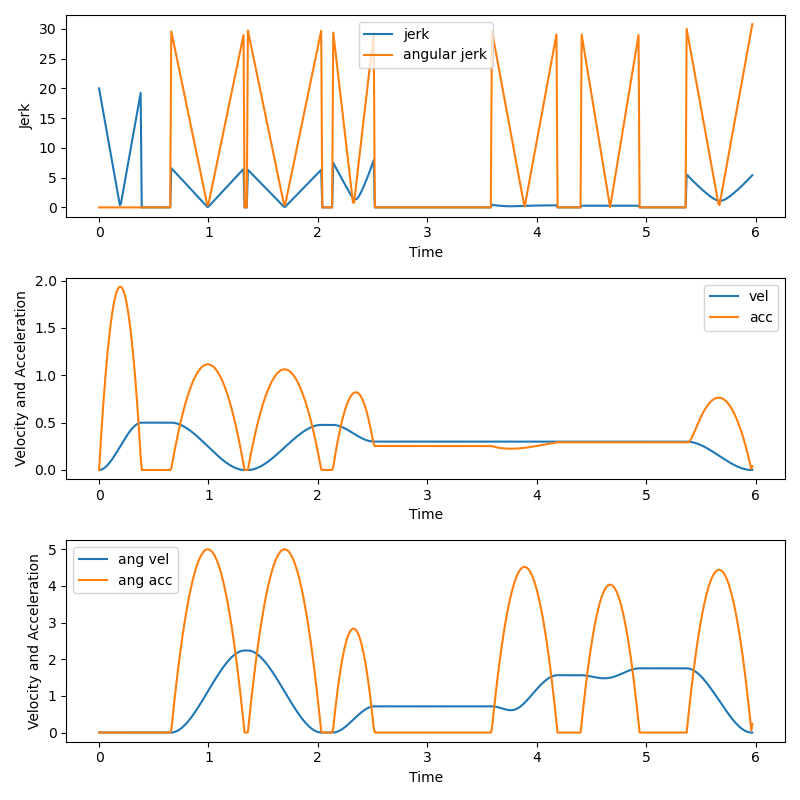

In [26]:
time_vec = np.arange(0, trajectory.time_vector[-1]+0.01, 0.01)

vel_norm_list = []
acc_norm_list = []
jerk_norm_list = []

ang_vel_norm_list = []
ang_acc_norm_list = []
ang_jerk_norm_list = []

quaternion_list = []

x = []
y = []
z = []

for t in time_vec:
    
    pos, vel, acc, jerk, quaternion, ang_vel, ang_acc, ang_jerk = trajectory.evaluate(t)
    
    vel_norm_list.append(np.linalg.norm(vel))
    acc_norm_list.append(np.linalg.norm(acc))
    jerk_norm_list.append(np.linalg.norm(jerk))
    
    ang_vel_norm_list.append(np.linalg.norm(ang_vel))
    ang_acc_norm_list.append(np.linalg.norm(ang_acc))
    ang_jerk_norm_list.append(np.linalg.norm(ang_jerk))
    
    quaternion_list.append(quaternion)
    
    x.append(pos[0])
    y.append(pos[1])
    z.append(pos[2])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

ax1.plot(time_vec, jerk_norm_list, label = "jerk")
ax1.plot(time_vec, ang_jerk_norm_list, label = "angular jerk")
ax1.set_xlabel('Time')
ax1.set_ylabel('Jerk')
ax1.legend()

ax2.plot(time_vec, vel_norm_list, label = "vel")
ax2.plot(time_vec, acc_norm_list, label = "acc")
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity and Acceleration')
ax2.legend()

ax3.plot(time_vec, ang_vel_norm_list, label = "ang vel")
ax3.plot(time_vec, ang_acc_norm_list, label = "ang acc")
ax3.set_xlabel('Time')
ax3.set_ylabel('Velocity and Acceleration')
ax3.legend()

# # Adjust the layout and display the plot
plt.tight_layout()
plt.show()

From the plots it is visible that the previously set limits for acceleration $a_{max} = 2$ and jerk $j_{max} = 20$ for the translational interpolation, as well as $\dot{\omega}_{max} = 5$ and jerk $\ddot{\omega}_{max} = 30$ are respected by the algorithm. The defined translational velocites for the linear segments $v_{des, linear} = 0.4$ and $v_{des, circular} = 0.5$ are followed precisely if the motion is possible without violation of the acceleration and jerk limits, and slowed down if not. 

The 3D trajectory is visiualized and animated by execution of the next code block.

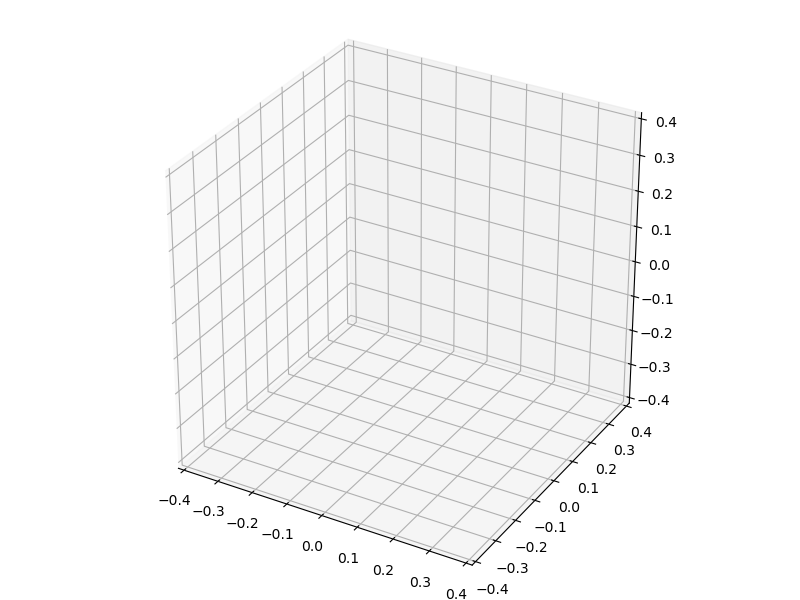

In [27]:
# Create a new figure for the 3D plot
fig_3d = plt.figure(figsize=(8, 6))

# Create 3D axes
ax_3d = fig_3d.add_subplot(111, projection='3d')
fig_3d.canvas.header_visible = False
size = 0.4
ax_3d.set_xlim([-size, size])
ax_3d.set_ylim([-size, size])
ax_3d.set_zlim([-size, size])
ax_3d.set_box_aspect([1, 1, 1])
plt.tight_layout()
# Define the update function for the animation
def update(frame):
    ax_3d.cla()  # Clear the previous plot
    ax_3d.set_xlim([-size, size])
    ax_3d.set_ylim([-size, size])
    ax_3d.set_zlim([-size, size])
    ax_3d.set_box_aspect([1, 1, 1])
    ax_3d.set_facecolor('white')
    ax_3d.set_axis_off()
    for spine in ax_3d.spines.values():
        spine.set_visible(False)
        
    # Draw the trajectory
    ax_3d.plot(x, y, z, label='Trajectory')
    
    # Draw the dot at the current position
    #ax_3d.scatter(x[frame], y[frame], z[frame], color='red')
    
    R = quaternion_list[frame].asRotationMatrix()*0.15
    # Draw coordinate frame (quiver arrows)
    #x_axis = ax.quiver(*start_point, *R[:,0], arrow_length_ratio = 0.1, linewidth = 1, color='r')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,0], color='red', label='X')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,1], color='green', label='Y')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,2], color='blue', label='Z')
    
    # Set labels and legend
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.legend()

# Create the FuncAnimation object with a smaller interval for faster animation
ani = animation.FuncAnimation(fig_3d, update, frames=len(x), repeat=False, interval=0.01)

# Display the animation
plt.show()

The current trajectory is defined as a position vector $p_{int} \in \mathbb{R}^3$ and an orientation quaternion $\hat{q}_{int} \in S^3$, as well as the corresponding angular and linear velocities and accelerations. For the execution of the <a href="./3.2_dual_quaternion_differential_kinematics.ipynb">dual quaternion differential kinematics</a> these states have to be expressed as dual quaternions. This means that we need to transform the position, orientation and the velocities and acceleration back into the dual quaternion space $\mathbb{H}$. 

The solution for the position level dual quaternion $\underline{\xi}_{int} = \hat{q}_r + \epsilon \hat{q}_d$ is trivial and given as

$$
    \underline{\xi}_{int} = \hat{q}_{int} + \epsilon \frac{1}{2}\bar{p}_{int} \otimes \hat{q}_{int}
$$

The first derivative of the interpolated orientation quaternion is given by $\frac{1}{2} \bar{\omega}_{int} \otimes \hat{q}_{int}$. For the translation part, the derivative is $\frac{1}{2} (\bar{\omega}_{int} \otimes \hat{q}_d + \bar{v}_{int} \otimes \hat{q}_r)$. Combining these, we get:

$$
    \dot{\underline{\xi}}_{int} = \frac{1}{2} (\bar{\omega}_{int} \otimes \hat{q}_{r} + \epsilon(\bar{\omega}_{int} \otimes \hat{q}_d + \bar{v}_{int} \otimes \hat{q}_r))
$$

This results in the first derivative of the interpolated dual quaternion $\dot{\underline{\xi}}_{int} = \dot{\hat{q}}_r + \epsilon \dot{\hat{q}}_d$ which is used for the differential kinematics computation. To retrieve the full unit dual quaternion state and also enable second order differential kinematics in $\mathbb{H}$, the online interpolation algorithm is extended to also return the acceleration level dual quaternion. Details of the implementation can be found in the <a href="./DualQuaternionQuinticBlends/DQQBTrajectoryGenerator.py">DQQBTrajectoryGenerator.py</a> file.

An example is shown in the following code block. For clearity only the dual parts of the respecitive dual quaternion and derivatives are shown

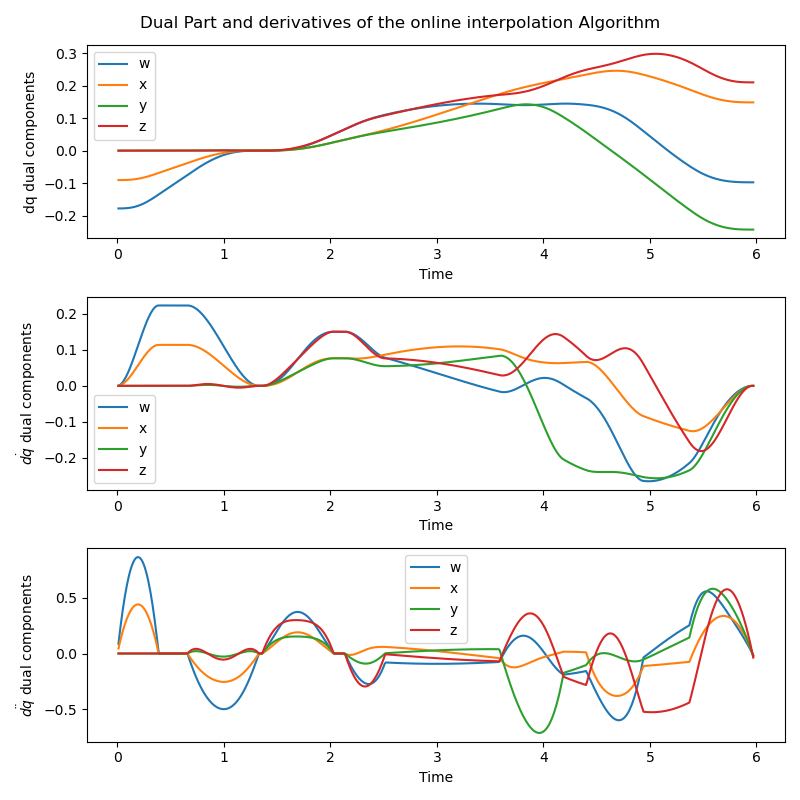

In [28]:
time_vec = np.arange(0.01, trajectory.time_vector[-1]+0.01, 0.01)

dq_list = []
dq_dot_list = []
dq_ddot_list = []

for t in time_vec:
    
    dq, dq_dot, dq_ddot = trajectory.evaluateDQ(t)
    
    dq_list.append(dq.dual.asVector().flatten())
    dq_dot_list.append(dq_dot.dual.asVector().flatten())
    dq_ddot_list.append(dq_ddot.dual.asVector().flatten())

    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle("Dual Part and derivatives of the online interpolation Algorithm")
ax1.plot(time_vec, dq_list, label = ["w", "x", "y", "z"])
ax1.set_xlabel('Time')
ax1.set_ylabel("dq dual components")
ax1.legend()

ax2.plot(time_vec, dq_dot_list, label = ["w", "x", "y", "z"])
ax2.set_xlabel('Time')
ax2.set_ylabel("$\dot{dq}$ dual components")
ax2.legend()

ax3.plot(time_vec, dq_ddot_list, label = ["w", "x", "y", "z"])
ax3.set_xlabel('Time')
ax3.set_ylabel("$\ddot{dq}$ dual components")
ax3.legend()

# # Adjust the layout and display the plot
plt.tight_layout()
plt.show()

<h1> Literature </h1>
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
</div>
<!-- BIBLIOGRAPHY END -->